# Linear Classifiers in Python - Part 3
- Logistic Regression Regularization
    - larger C, less regularization
    - smaller C, more regularization
    - more regularization, lower training accuracy, higher test accuracy
- L1 vs L2 Regularization (penalty hyperparameter)
    - Lasso = L1 - set coefficients to 0 (feature selection)
    - Ridge = L2 - make coefficients smaller
- Regularization combat overfitting
- There is a connection between overconfidence and overfitting
- Smaller coefficients mean less confident predictions
- Ratio of coefficients represents slope of the line
- Magnitude od coefficents represents confidence level
- Binary-class classification
    - one coefficient per feature
    - one intercept
- Multi-class classification (multi_class hyperparameter)
    - one-vs-rest (binary classifier for each class and select largest model output)
    - multinomial/softmax (single classifier for all classes)
    - one coefficient per feature per class
    - one intercept per class

In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import GridSearchCV

SEED = 1

In [86]:
def plot_classifier(X, y, clf, ax=None, ticks=False, proba=False, lims=None): # assumes classifier "clf" is already fit
    X0, X1 = X[:, 0], X[:, 1]
    xx, yy = make_meshgrid(X0, X1, lims=lims)

    if ax is None:
        plt.figure()
        ax = plt.gca()
        show = True
    else:
        show = False

    # can abstract some of this into a higher-level function for learners to call
    cs = plot_contours(ax, clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8, proba=proba)
    if proba:
        cbar = plt.colorbar(cs)
        cbar.ax.set_ylabel('probability of red $\Delta$ class', fontsize=20, rotation=270, labelpad=30)
        cbar.ax.tick_params(labelsize=14)
    #ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=30, edgecolors='k', linewidth=1)
    labels = np.unique(y)
    if len(labels) == 2:
        ax.scatter(X0[y==labels[0]], X1[y==labels[0]], cmap=plt.cm.coolwarm, s=60, c='b', marker='o', edgecolors='k')
        ax.scatter(X0[y==labels[1]], X1[y==labels[1]], cmap=plt.cm.coolwarm, s=60, c='r', marker='^', edgecolors='k')
    else:
        ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=50, edgecolors='k', linewidth=1)

    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
#     ax.set_xlabel(data.feature_names[0])
#     ax.set_ylabel(data.feature_names[1])
    if ticks:
        ax.set_xticks(())
        ax.set_yticks(())
#     ax.set_title(title)
    if show:
        plt.show()
    else:
        return ax
    
def make_meshgrid(x, y, h=.02, lims=None):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """

    if lims is None:
        x_min, x_max = x.min() - 1, x.max() + 1
        y_min, y_max = y.min() - 1, y.max() + 1
    else:
        x_min, x_max, y_min, y_max = lims
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, proba=False, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    if proba:
        Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:,-1]
        Z = Z.reshape(xx.shape)
        out = ax.imshow(Z,extent=(np.min(xx), np.max(xx), np.min(yy), np.max(yy)), origin='lower', vmin=0, vmax=1, **params)
        ax.contour(xx, yy, Z, levels=[0.5])
    else:
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        out = ax.contourf(xx, yy, Z, **params)
    return out

In [41]:
def show_digit(i, lr=None):
    plt.imshow(np.reshape(X[i], (8,8)), cmap='gray', vmin = 0, vmax = 16, interpolation=None)
    plt.xticks(())
    plt.yticks(())
    if lr is None:
        plt.title("class label = %d" % y[i])
    else:
        pred = lr.predict(X[i][None])
        pred_prob = lr.predict_proba(X[i][None])[0,pred]
        plt.title("label=%d, prediction=%d, proba=%.2f" % (y[i], pred, pred_prob))
    plt.show()

## Datasets

### Digits

In [3]:
digits = datasets.load_digits()

### Wine

In [4]:
wine = datasets.load_wine()

### Toy 2D

In [74]:
toy2d = np.load('../datasets/toy2D.npz')

In [77]:
toy2d.files

['X', 'y', 'Xvalid', 'yvalid']

## Logistic regression
In this chapter you will delve into the details of logistic regression. You'll learn all about regularization and how to interpret model output.

### Regularized logistic regression
In Chapter 1, you used logistic regression on the handwritten digits data set. Here, we'll explore the effect of L2 regularization.

The handwritten digits dataset is already loaded, split, and stored in the variables X_train, y_train, X_valid, and y_valid. The variables train_errs and valid_errs are already initialized as empty lists.

In [9]:
X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target, random_state=SEED)

In [10]:
# Train and validaton errors initialized as empty list
train_errs = list()
test_errs = list()

In [11]:
# Loop over values of C_value
C_values = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
for C_value in C_values:
    # Create LogisticRegression object and fit
    lr = LogisticRegression(C=C_value)
    lr.fit(X_train, y_train)
    
    # Evaluate error rates and append to lists
    train_errs.append( 1.0 - lr.score(X_train, y_train) )
    test_errs.append( 1.0 - lr.score(X_test, y_test) )

/Users/lukasz/anaconda/envs/data-camp/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:937: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/lukasz/anaconda/envs/data-camp/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:937: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules

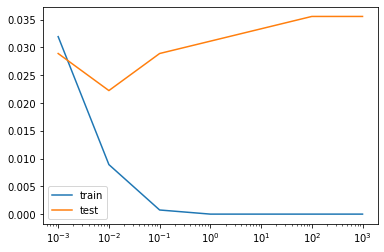

In [12]:
# Plot results
plt.semilogx(C_values, train_errs, C_values, test_errs)
plt.legend(("train", "test"))
plt.show()

### Logistic regression and feature selection
In this exercise we'll perform feature selection on the movie review sentiment data set using L1 regularization. The features and targets are already loaded for you in X_train and y_train.

We'll search for the best value of C using scikit-learn's GridSearchCV(), which was covered in the prerequisite course.

In [19]:
# Specify L1 regularization
lr = LogisticRegression(penalty='l1', solver='liblinear')

In [20]:
# Instantiate the GridSearchCV object and run the search
searcher = GridSearchCV(lr, {'C':[0.001, 0.01, 0.1, 1, 10]})
searcher.fit(X_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l1',
                                          random_state=None, solver='liblinear',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [21]:
# Report the best parameters
print("Best CV params", searcher.best_params_)

Best CV params {'C': 1}


In [22]:
# Find the number of nonzero coefficients (selected features)
best_lr = searcher.best_estimator_
coefs = best_lr.coef_
print("Total number of features:", coefs.size)
print("Number of selected features:", np.count_nonzero(coefs))

Total number of features: 640
Number of selected features: 362


### Identifying the most positive and negative words
In this exercise we'll try to interpret the coefficients of a logistic regression fit on the movie review sentiment dataset. The model object is already instantiated and fit for you in the variable lr.

In addition, the words corresponding to the different features are loaded into the variable vocab. For example, since vocab[100] is "think", that means feature 100 corresponds to the number of times the word "think" appeared in that movie review.

In [ ]:
# Get the indices of the sorted cofficients
inds_ascending = np.argsort(lr.coef_.flatten()) 
inds_descending = inds_ascending[::-1]

# Print the most positive words
print("Most positive words: ", end="")
for i in range(5):
    print(vocab[inds_descending[i]], end=", ")
print("\n")

# Print most negative words
print("Most negative words: ", end="")
for i in range(5):
    print(vocab[inds_ascending[i]], end=", ")
print("\n")

### Regularization and probabilities
In this exercise, you will observe the effects of changing the regularization strength on the predicted probabilities.

A 2D binary classification dataset is already loaded into the environment as X and y.

In [32]:
X, y = wine.data[:, :2], wine.target == 0

In [34]:
# Set the regularization strength to 1
model = LogisticRegression(C=1)

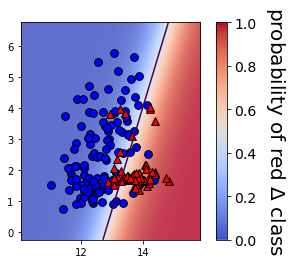

In [35]:
# Fit and plot
model.fit(X,y)
plot_classifier(X,y,model,proba=True)

In [36]:
# Predict probabilities on training points
prob = model.predict_proba(X)
print("Maximum predicted probability", np.max(prob))

Maximum predicted probability 0.9987420743146816


In [38]:
# Set the regularization strength to 0.1
model = LogisticRegression(C=0.1)

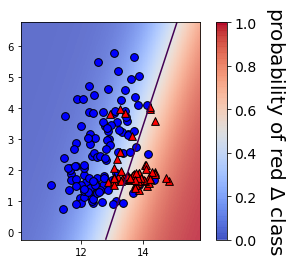

In [39]:
# Fit and plot
model.fit(X,y)
plot_classifier(X,y,model,proba=True)

In [40]:
# Predict probabilities on training points
prob = model.predict_proba(X)
print("Maximum predicted probability", np.max(prob))

Maximum predicted probability 0.9785301092291061


### Visualizing easy and difficult examples
In this exercise, you'll visualize the examples that the logistic regression model is most and least confident about by looking at the largest and smallest predicted probabilities.

The handwritten digits dataset is already loaded into the variables X and y. The show_digit function takes in an integer index and plots the corresponding image, with some extra information displayed above the image.

In [42]:
X, y = digits.data, digits.target

In [43]:
lr = LogisticRegression()
lr.fit(X,y)

/Users/lukasz/anaconda/envs/data-camp/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:937: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [44]:
# Get predicted probabilities
proba = lr.predict_proba(X)

In [45]:
# Sort the example indices by their maximum probability
proba_inds = np.argsort(np.max(proba,axis=1))

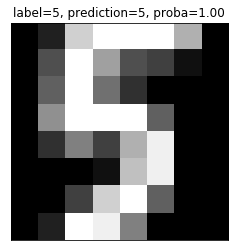

In [46]:
# Show the most confident (least ambiguous) digit
show_digit(proba_inds[-1], lr)

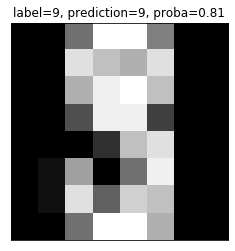

In [47]:
# Show the least confident (most ambiguous) digit
show_digit(proba_inds[0], lr)

### Fitting multi-class logistic regression
In this exercise, you'll fit the two types of multi-class logistic regression, one-vs-rest and softmax/multinomial, on the handwritten digits data set and compare the results. The handwritten digits dataset is already loaded and split into X_train, y_train, X_test, and y_test.

In [25]:
X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target, random_state=SEED)

In [26]:
# Fit one-vs-rest logistic regression classifier
lr_ovr = LogisticRegression()
lr_ovr.fit(X_train, y_train)

/Users/lukasz/anaconda/envs/data-camp/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:937: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [27]:
print("OVR training accuracy:", lr_ovr.score(X_train, y_train))
print("OVR test accuracy    :", lr_ovr.score(X_test, y_test))

OVR training accuracy: 1.0
OVR test accuracy    : 0.9688888888888889


In [28]:
# Fit softmax classifier
lr_mn = LogisticRegression(solver='lbfgs', multi_class='multinomial')
lr_mn.fit(X_train, y_train)

/Users/lukasz/anaconda/envs/data-camp/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:937: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [29]:
print("Softmax training accuracy:", lr_mn.score(X_train, y_train))
print("Softmax test accuracy    :", lr_mn.score(X_test, y_test))

Softmax training accuracy: 1.0
Softmax test accuracy    : 0.9688888888888889


### Visualizing multi-class logistic regression
In this exercise we'll continue with the two types of multi-class logistic regression, but on a toy 2D data set specifically designed to break the one-vs-rest scheme.

The data set is loaded into X_train and y_train. The two logistic regression objects,lr_mn and lr_ovr, are already instantiated (with C=100), fit, and plotted.

Notice that lr_ovr never predicts the dark blue class... yikes! Let's explore why this happens by plotting one of the binary classifiers that it's using behind the scenes.

In [89]:
X_train, y_train = toy2d['X'], toy2d['y']

In [94]:
# Fit one-vs-rest logistic regression classifier
lr_ovr = LogisticRegression(C=100, multi_class='ovr')
lr_ovr.fit(X_train, y_train)

LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='ovr', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

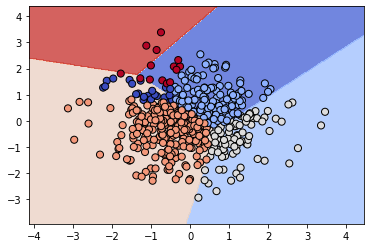

In [95]:
plot_classifier(X_train, y_train, lr_ovr)

In [96]:
# Fit softmax classifier
lr_mn = LogisticRegression(C=100, solver='lbfgs', multi_class='multinomial')
lr_mn.fit(X_train, y_train)

LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

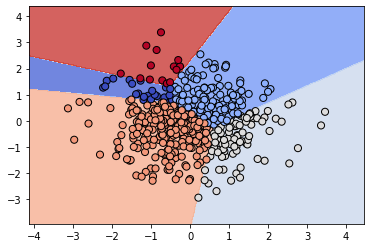

In [97]:
plot_classifier(X_train, y_train, lr_mn)

In [98]:
# Print training accuracies
print("Softmax     training accuracy:", lr_mn.score(X_train, y_train))
print("One-vs-rest training accuracy:", lr_ovr.score(X_train, y_train))

Softmax     training accuracy: 0.996
One-vs-rest training accuracy: 0.916


In [99]:
# Create the binary classifier (class 1 vs. rest)
lr_class_1 = LogisticRegression(C=100)
lr_class_1.fit(X_train, y_train==1)

LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

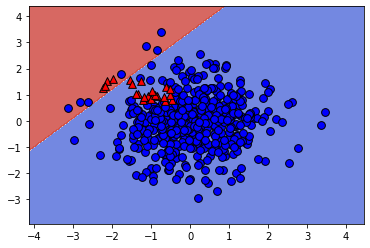

In [100]:
# Plot the binary classifier (class 1 vs. rest)
plot_classifier(X_train, y_train==1, lr_class_1)

### One-vs-rest SVM
As motivation for the next and final chapter on support vector machines, we'll repeat the previous exercise with a non-linear SVM. Once again, the data is loaded into X_train, y_train, X_test, and y_test .

Instead of using LinearSVC, we'll now use scikit-learn's SVC object, which is a non-linear "kernel" SVM (much more on what this means in Chapter 4!). Again, your task is to create a plot of the binary classifier for class 1 vs. rest.

In [108]:
svm_ovr = OneVsRestClassifier(SVC())
svm_ovr.fit(X_train, y_train)

OneVsRestClassifier(estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                                  class_weight=None, coef0=0.0,
                                  decision_function_shape='ovr', degree=3,
                                  gamma='scale', kernel='rbf', max_iter=-1,
                                  probability=False, random_state=None,
                                  shrinking=True, tol=0.001, verbose=False),
                    n_jobs=None)

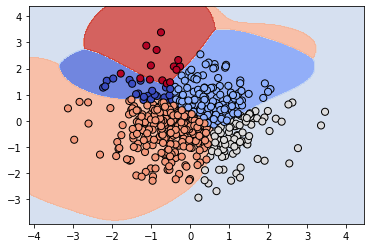

In [107]:
plot_classifier(X_train, y_train, svm_ovr)

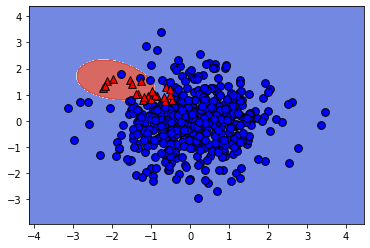

In [109]:
# Create/plot the binary classifier (class 1 vs. rest)
svm_class_1 = SVC()
svm_class_1.fit(X_train, y_train==1)
plot_classifier(X_train, y_train==1, svm_class_1)